In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
###Adam optimizer is well suited for large datasets and is computationally efficient
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report




# To obtain a listing of all image paths inside the dataset directory, we make a call to the list_images function


In [ ]:
dataset=r'/content/drive/MyDrive/Colab Notebooks/train'
imagePaths=list(paths.list_images(dataset))


In [ ]:
imagePaths

['/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_129.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/360.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_203.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_27.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_69.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/20.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_275.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/101.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/46.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_154.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_303.jpg',
 '/content/drive/MyDrive/Colab Notebooks/train/without_mask/augmented_image_282.jpg',
 '/content/drive/MyDrive/Colab Noteb

# Data preprocessing : 
create the data and the target from the dataset  

In [ ]:
data=[]
labels=[]

for i in imagePaths:
    label=i.split(os.path.sep)[-2] # 7atineha -2 bech nofslou num lphoto ala without mask wela avec mask 
    labels.append(label)
    image=load_img(i,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image) # hedhi bech ta3mel normalisation lel les pixels ou ldata = préprocessing data
    data.append(image)

In [ ]:
data[0].shape

(224, 224, 3)


# Transforme the list of data and target to a matrix 


In [ ]:
data=np.array(data,dtype='float32')  
labels=np.array(labels) 

In [ ]:
labels.shape

(1314,)

In [ ]:
data.shape

(1314, 224, 224, 3)

# Convert multi-class labels to binary labels (belong or does not belong to the class). LabelBinarizer makes this process easy with the transform method.

In [ ]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels) 

In [ ]:
labels

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

# Returns the number of categories selected in a category list.

In [ ]:
labels=to_categorical(labels)

In [ ]:
labels.shape

(1314, 2)

In [ ]:
labels[0]

array([0., 1.], dtype=float32)

# train_test_split is a function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data

In [ ]:
train_X,test_X,train_Y,test_Y=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=10)

In [ ]:
train_X.shape

(1051, 224, 224, 3)

# Image Augmentation

In [ ]:

aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

# Using a pretrained model eli houwa MobileNetV2


In [ ]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
baseModel.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Add the classification part to the pretrainde model

In [ ]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='Flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2, activation='softmax')(headModel) #softmax can be used in machine learning to convert a score into 
                                                          #  a probability in a multi-class classification context
model=Model(inputs=baseModel.input,outputs=headModel)

# freeze the trainable layers to conserve the weights 


In [ ]:
for layer in baseModel.layers:
  layer.trainable=False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

# Training our Model

In [ ]:
learning_rate=0.001
Epochs=20
BS=12

opt=Adam(lr=learning_rate,decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

H=model.fit(
    aug.flow(train_X,train_Y,batch_size=BS),
    steps_per_epoch=len(train_X)//BS,
    validation_data=(test_X,test_Y), #batch_size correspond au nombre d’exemples utilisé pour estimer le gradient de la fonction de coût
    validation_steps=len(test_X)//BS,
    epochs=Epochs
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
87/87 [==============================] - 44s 477ms/step - loss: 0.1936 - accuracy: 0.9297 - val_loss: 0.1034 - val_accuracy: 0.9620
Epoch 2/20
87/87 [==============================] - 41s 467ms/step - loss: 0.0688 - accuracy: 0.9769 - val_loss: 0.0755 - val_accuracy: 0.9696
Epoch 3/20
87/87 [==============================] - 41s 467ms/step - loss: 0.0432 - accuracy: 0.9846 - val_loss: 0.0984 - val_accuracy: 0.9620
Epoch 4/20
87/87 [==============================] - 41s 467ms/step - loss: 0.0474 - accuracy: 0.9875 - val_loss: 0.0789 - val_accuracy: 0.9696
Epoch 5/20
87/87 [==============================] - 41s 465ms/step - loss: 0.0415 - accuracy: 0.9856 - val_loss: 0.0819 - val_accuracy: 0.9734
Epoch 6/20
87/87 [==============================] - 41s 467ms/step - loss: 0.0352 - accuracy: 0.9856 - val_loss: 0.1062 - val_accuracy: 0.9696
Epoch 7/20
87/87 [==============================] - 41s 467ms/step - loss: 0.0519 - accuracy: 0.9769 - val_loss: 0.0851 - val_accuracy: 0.9658

# Evaluate our model on the data test

In [ ]:
résultat=model.evaluate(test_X,test_Y)

9/9 [==============================] - 6s 664ms/step - loss: 0.1039 - accuracy: 0.9658


In [ ]:
prediction=model.predict(test_X,batch_size=BS)

In [ ]:
prediction

array([[9.99428570e-01, 5.71381534e-04],
       [1.00000000e+00, 1.91676590e-21],
       [3.28673070e-12, 1.00000000e+00],
       [1.00000000e+00, 6.74692348e-18],
       [1.00000000e+00, 1.23137038e-08],
       [1.00000000e+00, 9.07376794e-14],
       [1.00000000e+00, 2.48070407e-23],
       [1.00000000e+00, 4.65543961e-15],
       [1.00000000e+00, 8.92234645e-18],
       [1.00000000e+00, 2.46706111e-13],
       [1.00000000e+00, 1.51243997e-20],
       [1.00000000e+00, 1.78414235e-22],
       [3.57697355e-15, 1.00000000e+00],
       [1.22334745e-16, 1.00000000e+00],
       [1.00000000e+00, 9.62457598e-16],
       [1.00000000e+00, 9.17839690e-18],
       [1.00000000e+00, 1.75776904e-14],
       [6.96720784e-13, 1.00000000e+00],
       [1.00000000e+00, 4.90859458e-16],
       [1.00000000e+00, 8.96338865e-25],
       [9.99981642e-01, 1.83065440e-05],
       [4.44549848e-11, 1.00000000e+00],
       [1.00000000e+00, 6.43358912e-18],
       [1.33874356e-10, 1.00000000e+00],
       [1.000000

In [ ]:
prdiction=np.argmax(prediction,axis=1)

In [ ]:
prdiction

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
print(classification_report(test_Y.argmax(axis=1),prdiction,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.96      0.98      0.97       132
without_mask       0.98      0.95      0.97       131

    accuracy                           0.97       263
   macro avg       0.97      0.97      0.97       263
weighted avg       0.97      0.97      0.97       263



# Saving the Model

In [ ]:
model.save(r'C:\Python37\Projects\face-mask-detector\mobilenet_v2.model')

INFO:tensorflow:Assets written to: C:\Python37\Projects\face-mask-detector\mobilenet_v2.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Face detection

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

In [ ]:
prototxtPath=os.path.sep.join([r'/content/drive/MyDrive/Colab Notebooks/Mask-Detection-and-Recognition-using-Deep-Learning-Keras-master/face-mask-detector/deploy.prototxt'])

In [ ]:
weightsPath=os.path.sep.join([r'/content/drive/MyDrive/Colab Notebooks/Mask-Detection-and-Recognition-using-Deep-Learning-Keras-master/face-mask-detector/res10_300x300_ssd_iter_140000.caffemodel'])

In [ ]:
prototxtPath

'/content/drive/MyDrive/Colab Notebooks/Mask-Detection-and-Recognition-using-Deep-Learning-Keras-master/face-mask-detector/deploy.prototxt'

In [ ]:
weightsPath

'/content/drive/MyDrive/Colab Notebooks/Mask-Detection-and-Recognition-using-Deep-Learning-Keras-master/face-mask-detector/res10_300x300_ssd_iter_140000.caffemodel'

# Create a model who can detecte faces from pictures

In [90]:
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [91]:
image=cv2.imread(r'/content/sample_data/lking.jpg')

In [92]:
image

array([[[193, 198, 199],
        [193, 198, 199],
        [193, 198, 199],
        ...,
        [167, 169, 163],
        [153, 155, 149],
        [ 87,  89,  83]],

       [[193, 198, 199],
        [193, 198, 199],
        [193, 198, 199],
        ...,
        [ 73,  75,  69],
        [ 80,  82,  76],
        [ 61,  63,  57]],

       [[193, 198, 199],
        [193, 198, 199],
        [193, 198, 199],
        ...,
        [ 61,  65,  60],
        [ 69,  73,  68],
        [ 66,  70,  65]],

       ...,

       [[177, 175, 175],
        [174, 172, 172],
        [179, 177, 177],
        ...,
        [ 77,  69,  69],
        [ 82,  75,  72],
        [ 76,  68,  68]],

       [[125, 123, 123],
        [126, 124, 124],
        [136, 134, 134],
        ...,
        [ 73,  64,  61],
        [ 66,  57,  53],
        [ 71,  62,  59]],

       [[124, 122, 122],
        [122, 120, 120],
        [130, 128, 128],
        ...,
        [136, 127, 123],
        [114, 105, 101],
        [102,  93,  89]]

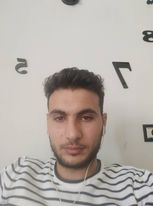

In [93]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [94]:
(h,w)=image.shape[:2]

# dnn. blobFromImage function returns a blob which is our input image after mean subtraction, normalizing, and channel swapping

In [ ]:
blob=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

In [ ]:
blob.shape

(1, 3, 300, 300)

In [ ]:
blob

array([[[[127., 127., 127., ..., 129., 129., 129.],
         [116., 130., 120., ..., 130., 130., 130.],
         [116., 119., 114., ..., 131., 131., 130.],
         ...,
         [ 80.,  80.,  81., ...,  80.,  80.,  78.],
         [ 82.,  82.,  82., ...,  75.,  75.,  74.],
         [ 85.,  85.,  85., ...,  70.,  73.,  71.]],

        [[ 51.,  58.,  59., ...,  30.,  30.,  30.],
         [ 48.,  54.,  53., ...,  31.,  31.,  30.],
         [ 49.,  55.,  53., ...,  31.,  31.,  30.],
         ...,
         [  4.,   4.,   5., ...,   7.,   7.,   5.],
         [  6.,   6.,   6., ...,   3.,   3.,   2.],
         [  9.,   9.,   9., ...,   7.,   9.,   8.]],

        [[109., 107., 107., ...,  60.,  60.,  60.],
         [101., 108., 113., ...,  61.,  61.,  61.],
         [105., 108., 110., ...,  64.,  64.,  63.],
         ...,
         [ 54.,  54.,  55., ...,  55.,  55.,  53.],
         [ 55.,  55.,  55., ...,  51.,  52.,  51.],
         [ 58.,  58.,  58., ...,  64.,  66.,  65.]]]], dtype=float32)

# forward declaration is a declaration of an identifier (denoting an entity such as a type, a variable, a constant, or a function) for which the programmer has not yet given a complete definition.

In [95]:
net.setInput(blob)
detections=net.forward()


In [ ]:
detections

array([[[[0.        , 1.        , 0.5156504 , ..., 0.53070474,
          0.343011  , 0.60785174],
         [0.        , 1.        , 0.33339134, ..., 0.5477934 ,
          0.54884166, 0.6075282 ],
         [0.        , 1.        , 0.30903122, ..., 0.51976407,
          0.18737881, 0.58497393],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

In [ ]:
detections.shape

(1, 1, 200, 7)

In [96]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
for i in range(0,detections.shape[2]):
    confidence=detections[0,0,i,2]
    
    
    if confidence>0.5:
        #we need the X,Y coordinates
        box=detections[0,0,i,3:7]*np.array([w,h,w,h])
        (startX,startY,endX,endY)=box.astype('int')
        
        #ensure the bounding boxes fall within the dimensions of the frame
        (startX,startY)=(max(0,startX),max(0,startY))
        (endX,endY)=(min(w-1,endX), min(h-1,endY))
        
        
        #extract the face ROI, convert it from BGR to RGB channel, resize it to 224,224 and preprocess it
        face=image[startY:endY, startX:endX] 
        face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face,(224,224))    #(224,224) puisque on a entrainer  notre model a des images de ce shape
        face=img_to_array(face)
        face=preprocess_input(face)
        face=np.expand_dims(face,axis=0) # expand dimension 
        
        (mask,withoutMask)=model.predict(face)[0]
        
        #determine the class label and color we will use to draw the bounding box and text
        label='Mask' if mask>withoutMask else 'No Mask'
        color=(0,255,0) if label=='Mask' else (0,0,255)
        
        #include the probability in the label
        label="{}: {:.2f}%".format(label,max(mask,withoutMask)*100)
        
        #display the label and bounding boxes
        cv2.putText(image,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(image,(startX,startY),(endX,endY),color,2)
        
        
        


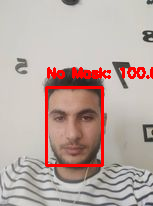

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)